# 评估 RAG 性能

---

祝贺你构建了第一个 RAG！RAG（Retrieval-Augmented Generation，检索增强生成）是打造实用型 LLM 应用最常见的方式之一。它让你能够引入外部知识，使你的 AI 助手或聊天机器人不再局限于模型在训练阶段记住的内容。

但加入检索功能也让整体复杂度显著提升。

此时你不再只是给 LLM 写提示词——你在搭建整条管线。这里涉及文本分块、检索、上下文拼装与生成。当出现问题时，根源往往不明：是模型幻觉？还是压根没有拿到正确的信息？

那么，在向用户发布之前，如何判断 RAG 系统的表现如何呢？这正是评估机制发挥作用的地方。

## 故事回顾

你已经成功把 RAG 整合进 **TaskFriend**，现在它可以访问应用中存放的其他信息。然而，你隐约觉得某处出了问题，于是对比了应用数据与 **TaskFriend** 的回答。果不其然——**TaskFriend** 会把部分信息弄错。你担心这可能只是冰山一角，可是完全靠人工排查显然不可行。

因此，你决定构建一个评估机制，帮助你自动化衡量 **TaskFriend** 的 RAG 功能表现如何。

## 目标

* 了解为什么人工评估适合调试，却无法在规模化场景下独立支撑。
* 学会逐步检查 RAG 管线，以定位故障点。
* 掌握 RAG 评估的核心维度：上下文召回、上下文精度、事实可信度与答案正确性。
* 搭建并使用 Ragas 来自动评估 RAG 系统。
* 解读评估指标，提炼可执行洞见，从而改进 RAG 管线。
* 比较常见的 RAG 评估框架，理解各自的适用场景。
* 建立可持续、专家参与的评估最佳实践流程。

## 初始化环境

### 设置 API 密钥

在开始任何笔记本的工作之前，我们需要加载 [Model Studio 的 API 密钥](https://modelstudio.console.alibabacloud.com/?tab=globalset#/efm/api_key)。这样才能调用我们在整个课程中使用的 Qwen 模型接口。

> 如果你不确定如何找到 **Model Studio** 的 API 密钥，请参考 `00 Setting Up the Environment` 文件。

In [1]:
# Load Model Studio API key
import os
from config.load_key import load_key
load_key(
    confirmation=False
)

Detected existing API key: sk-8...2716
Auto-confirmation enabled. Using existing API key.


### 配置 LLM 与嵌入模型

与上一课相同，我们将使用阿里云的 `qwen-plus` 作为 LLM，并使用 DashScope 的 `text-embedding-v3` 作为嵌入模型。

In [2]:
# Set global settings
import time
import logging
import dashscope
from llama_index.core import Settings, VectorStoreIndex, SimpleDirectoryReader
from llama_index.embeddings.dashscope import DashScopeEmbedding
from llama_index.llms.openai_like import OpenAILike
from pathlib import Path

logging.getLogger().setLevel(logging.ERROR)

# Route DashScope calls to the mainland China endpoints
dashscope.base_http_api_url = "https://dashscope.aliyuncs.com/api/v1"

Settings.llm = OpenAILike(
    model="qwen-plus",
    api_base="https://dashscope.aliyuncs.com/compatible-mode/v1",
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    is_chat_model=True
)

Settings.embed_model = DashScopeEmbedding(
    model_name="text-embedding-v3",
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    encoding_format="float"
)

print("✅ Global parameters set!")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/chengzh/.venv/lib/python3.12/site-
[nltk_data]     packages/llama_index/core/_static/nltk_cache...
[nltk_data]   Package punkt_tab is already up-to-date!


✅ Global parameters set!


# RAG 评估流程

--- 

```mermaid
graph LR
    A[手动评估] --> B[手动排障] --> C[自动化评估]
```

在真实生产环境中，由于需要处理的数据量巨大，评估 RAG 系统通常最好交给**自动化评估**方法。不过，今天我们聚焦在较小的范围——我们新搭建的 **TaskFriend** 应用。

## 手动评估：找出问题

在先前的示例中，你或许记得出现过类似的对话：

```
🚀 TaskFriend Conversation
------------------------------------------------------------
👤 You: How many tasks do I need to complete today?

🤖 TaskFriend is thinking...
🤖 TaskFriend: You have one task that is due today.

------------------------------------------------------------
```

然而，当我们查看 `tasks.pdf` 时，却发现事实并非如此：


| ID | 任务 | 类型 | 截止 | 状态 | 备注 |
|----|------|------|-----|--------|-------|
| 01 | 下午 3 点前完成 Q3 OKR | 一次性 | ⭐今天 | 待处理 | 与各部门负责人协作以对齐可量化目标，制定实现目标的可靠计划，并为团队成员分配职责。 |
| 03 | 新成员入职安排 | 一次性 | ⭐今天 | 已完成 | 安排与团队成员的介绍会议，发送包含入职清单的欢迎邮件，为前 30 天指定导师。<br>Karen 已被指派为新成员的导师。 |
| 05 | 更新凤凰项目路线图 | 一次性 | ⭐今天 | 待处理 | 与项目负责人同步以反映最新时间线、里程碑和资源分配，并考虑供应链中断的最新变化。 |
| 10 | 给韩国笔友写感谢信 | 一次性 | ⭐今天 | 进行中 | 感谢在规划挪威旅行时提供帮助的韩国笔友，并记得询问他们新出生的儿子 Edwin 的近况。 |


那么发生了什么？这个问题的根源是什么？

## 排查你的 RAG：上手实践

让我们再运行一次由 RAG 驱动的 **TaskFriend**。但这次，我们会同时**打印 RAG 从索引中检索到的文本块（或节点）**。

另外，我们还会添加一个自定义的 `highlight_words` 函数，以便更清晰地观察输出。稍后你就会明白它的作用。

In [3]:
def highlight_words(text, words_to_highlight, emoji="⭐"):
    for word in words_to_highlight:
        if word in text:
            text = text.replace(word, f"{emoji}{word}{emoji}")
    return text


def get_rag_response_with_info(query, query_engine, highlight=None):
    print("🚀 TaskFriend Conversation (single-round)")
    print("-" * 50)
    print(f'👤 You: {query}')
    
    try:
        # 🔍 Query the RAG engine
        response = query_engine.query(query)

        # 🧠 Extract the answer
        if hasattr(response, 'response'):
            answer = response.response
        else:
            answer = str(response)

        # 📚 Show source references AFTER the answer
        print("🤖 TaskFriend:", answer)
        print('\n\n' + '=' * 50)
        print('📚 References\n')
        
        highlight = highlight or []
        for i, source_node in enumerate(response.source_nodes, start=1):
            print(f'Chunk {i}:')
            
            # Highlight words in chunk
            highlighted_text = highlight_words(source_node.text, highlight)
            print(highlighted_text)
            print()
        print('=' * 50)

        return answer

    except Exception as e:
        print(f"[RAG Error] {e}")
        return "[Error retrieving response]"


由于我们在上一章节已经构建并保存了索引，因此现在只需要从保存的位置（`./knowledge_base/taskfriend`）加载即可。

这里我们会用到 `llama_index` 中的一些函数：

* `StorageContext:` 存储上一章保存的节点、嵌入与向量库，使你的代码能够定位并连接这些数据，这样就无需重新处理所有文档，就能重新加载整个知识库。
* `load_index_from_storage:` 根据保存在 `StorageContext` 中的文件重建 RAG 索引。这是让 RAG 系统快速再次运行的最高效方式。

In [4]:
from llama_index.core import StorageContext, load_index_from_storage

persist_path="./knowledge_base/taskfriend"

# Import index ("knowledgebase") we built last chapter,
storage_context = StorageContext.from_defaults(
    persist_dir=persist_path,
)

index = load_index_from_storage(
    storage_context,
    embed_model=Settings.embed_model
)
print(f"✅ Index loaded from `{persist_path}`!")

# Build the query engine (used to implement RAG)
query_engine = index.as_query_engine(
    streaming=False,
    llm=Settings.llm,
)
print("✅ Query engine built!")

✅ Index loaded from `./knowledge_base/taskfriend`!
✅ Query engine built!


现在我们就可以再次运行同样的查询，只不过这一次会同时查看 **TaskFriend** 获取信息的来源。

In [5]:
# User query
query = "How many tasks do I need to complete today?"

# Choose words to highlight
highlight = ["Today"]

response = get_rag_response_with_info(query, query_engine=query_engine, highlight=highlight)

🚀 TaskFriend Conversation (single-round)
--------------------------------------------------
👤 You: How many tasks do I need to complete today?
🤖 TaskFriend: You need to complete 1 task today.


📚 References

Chunk 1:
Tasks   ID Task Type Due Status Notes 
01 Finalize Q3 OKRs by 3pm One-oﬀ ⭐Today⭐ Pending  Collaborate with department heads to align on measurable objecDves, lay out solid plan to achieve objecDves and assign responsibility to team members.   
02 Prepare presentaDon for client review One-oﬀ This Week Pending  Focus on deliverables from Q2, highlight success metrics, and outline next steps. Obtain client feedback on presentaDon and tweak direcDon based on

Chunk 2:
client preferences.   
03 Onboard new team member One-oﬀ ⭐Today⭐ Done  Schedule intro meeDngs with team members, send welcome email with onboarding checklist, assign mentor for ﬁrst 30 days.  Karen was assigned to be the mentor for the new team member.   04 Review team feedback survey results One-oﬀ This Week Pen

现在我们会看到类似这样的输出：

```
🚀 TaskFriend Conversation (single-round)
--------------------------------------------------
👤 You: How many tasks do I need to complete today?
🤖 TaskFriend: You need to complete two tasks today. One is to finalize Q3 OKRs by 3 pm, and the other is to onboard a new team member, which has already been marked as done.


==================================================
📚 References

Chunk 1:
Tasks   ID Task Type Due Status Notes 
01 Finalize Q3 OKRs by 3pm One-oﬀ ⭐Today⭐ Pending  Collaborate with department heads to align on measurable objecDves, lay out solid plan to achieve objecDves and assign responsibility to team members.   
02 Prepare presentaDon for client review One-oﬀ This Week Pending  Focus on deliverables from Q2, highlight success metrics, and outline next steps. Obtain client feedback on presentaDon and tweak direcDon based on

Chunk 2:
client preferences.   
03 Onboard new team member One-oﬀ ⭐Today⭐ Done  Schedule intro meeDngs with team members, send welcome email with onboarding checklist, assign mentor for ﬁrst 30 days.  Karen was assigned to be the mentor for the new team member.   04 Review team feedback survey results One-oﬀ This Week Pending  Analyze anonymous feedback from recent engagement survey and idenDfy top 3 pain points and 2 strengths.

==================================================
```

几件事情会格外显眼：

* 单词 `Today` 只出现了两次。（感谢 `highlight_words` 帮我们突显！）
* RAG 只检索了 *2 个文本块*。
* 解析器似乎出现了问题，特别是一些拼写：
    * Executive → ExecuHve
    * meeDngs → meetings
    
基于这些线索，你已经成功确定了 RAG 系统问题的根源。

# 自动化评估

---

对于一次性场景或像 TaskFriend 这种早期开发阶段的应用来说，手动评估与排障完全没有问题——深入探究开发细节也能帮助你快速成长。但一旦规模上来，靠人工逐条排查问题就越来越不可行了。

接下来我们看看如何让这个流程实现自动化。

In [6]:
from langchain_openai import ChatOpenAI
from langchain_dashscope import DashScopeEmbeddings 
import os
import time

dashscope.base_http_api_url = "https://dashscope.aliyuncs.com/api/v1"

# LangChain LLM for Ragas
ragas_llm = ChatOpenAI(
    model="qwen-plus",
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    timeout=60,
    max_retries=3
)

# LangChain Embeddings for Ragas
ragas_embeddings = DashScopeEmbeddings(
    model="text-embedding-v3",
    api_key=os.getenv("DASHSCOPE_API_KEY")
)

print("✅ LLM and Embeddings pipeline for Ragas successfully built!")

✅ LLM and Embeddings pipeline for Ragas successfully built!


In [7]:
# Create a new query engine for evaluation
query_engine = index.as_query_engine(
    llm=ragas_llm,
    embed_model=Settings.embed_model,
    streaming=False  # Disable streaming for evaluation
)

print("✅ Query engine built!")

✅ Query engine built!


In [8]:
# Define test cases
test_cases = [
    {
        "question": "How many tasks do I need to complete today?",
        "ground_truth": (
            "You have 3 tasks to complete today: Finalize Q3 OKRs, "
            "Update Project Phoenix roadmap, and Write thank-you letter to penpal."
        )
    },
    {
        "question": "Am I planning a trip somewhere?",
        "ground_truth": "You are planning a trip to Norway."
    },
    {
        "question": "When is the 'Develop 3-year plan' task due?",
        "ground_truth": "This year"
    },
    {
        "question": "What are the one-time and recurring tasks for 'Project Phoenix'? Be brief.",
        "ground_truth": (
            "One-time tasks: Updating the project roadmap; "
            "Recurring tasks: Generating weekly reports."
        )       
    },    
]

print("✅ Test cases defined!")

✅ Test cases defined!


In [9]:
from functions.html_table import create_html_table

# Define function to run test cases with evaluator LLM
def run_test_cases(query_engine, test_cases):
    results = {
        "question": [],
        "answer": [],
        "contexts": [],  # Store raw contexts for Dataset
        "contexts_display": [],  # Store formatted contexts for display
        "ground_truth": []
    }
    
    print("Generating answers based on test cases...", end="", flush=True)
    start_time = time.time()
    
    for case in test_cases:
        # Get response
        response = query_engine.query(case["question"])
        
        # Extract answer and context
        answer = str(response).strip()
        # Ensure contexts is a list of strings
        contexts = [node.get_content().strip() for node in response.source_nodes]
        
        # Format contexts for display with [] and line breaks
        contexts_display = [f"[{ctx}]" for ctx in contexts]
        
        # Store results
        results["question"].append(case["question"])
        results["answer"].append(answer)
        results["contexts"].append(contexts)
        results["contexts_display"].append("⭐".join(contexts_display)) # Use this to better visualize breaks between contexts
        results["ground_truth"].append(case["ground_truth"])
    
    load_time = time.time() - start_time
    print(f" ✅ Done ({load_time:.1f} seconds)")
    
    return results

# Run the test
test_results = run_test_cases(query_engine, test_cases)

table_data = {
    "question": test_results["question"],
    "answer": test_results["answer"],
    "ground_truth": test_results["ground_truth"],
    "contexts": test_results["contexts_display"],
}

# Use 5:15:15:15:50 percentage distribution (index + 4 columns)
create_html_table(
    table_data, 
    title="RAG Evaluation Results", 
    column_widths=[5, 15, 15, 15, 50]  # index:question:contexts:ground_truth:answer
)

Generating answers based on test cases...

/home/chengzh/.venv/lib/python3.12/site-packages/llama_index/llms/langchain/base.py:95: LangChainDeprecationWarning: The method `BaseChatModel.predict_messages` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use invoke instead.
  lc_message = self._llm.predict_messages(messages=lc_messages, **kwargs)


 ✅ Done (4.6 seconds)


#,question,answer,ground_truth,contexts
1,How many tasks do I need to complete today?,You need to complete 2 tasks today.,"You have 3 tasks to complete today: Finalize Q3 OKRs, Update Project Phoenix roadmap, and Write thank-you letter to penpal.","[Tasks ID Task Type Due Status Notes 01 Finalize Q3 OKRs by 3pm One-oﬀ Today Pending Collaborate with department heads to align on measurable objecDves, lay out solid plan to achieve objecDves and assign responsibility to team members. 02 Prepare presentaDon for client review One-oﬀ This Week Pending Focus on deliverables from Q2, highlight success metrics, and outline next steps. Obtain client feedback on presentaDon and tweak direcDon based on]⭐[client preferences. 03 Onboard new team member One-oﬀ Today Done Schedule intro meeDngs with team members, send welcome email with onboarding checklist, assign mentor for ﬁrst 30 days. Karen was assigned to be the mentor for the new team member. 04 Review team feedback survey results One-oﬀ This Week Pending Analyze anonymous feedback from recent engagement survey and idenDfy top 3 pain points and 2 strengths.]"
2,Am I planning a trip somewhere?,"Yes, you are planning a trip to Norway.",You are planning a trip to Norway.,"[trends, dra` a long-term vision for the team, and resent dra` at annual planning retreat. 10 Write thank-you le[er to penpal in Korea One-oﬀ Today Started Thank penpal in Korea for the help they provided when you needed advice on planning a trip to Norway, and remember to ask them about their newborn son, Edwin.]⭐[05 Update Project Phoenix roadmap One-oﬀ Today Pending Sync with project leads to reﬂect latest Dmelines, milestones, and resource allocaDons, taking into account the latest changes to supply-chain disrupDons. 06 Schedule 1:1s with team One-oﬀ This Month Pending Book 30-minute slots via calendar invite with each team member over the next 4 weeks, focus agenda on career paths, workload balance, and feedback. 07 Call bank regarding home loan One-oﬀ This Week Pending Contact customer service to]"
3,When is the 'Develop 3-year plan' task due?,The 'Develop 3-year plan' task is due This Year.,This year,"[Tasks ID Task Type Due Status Notes 01 Finalize Q3 OKRs by 3pm One-oﬀ Today Pending Collaborate with department heads to align on measurable objecDves, lay out solid plan to achieve objecDves and assign responsibility to team members. 02 Prepare presentaDon for client review One-oﬀ This Week Pending Focus on deliverables from Q2, highlight success metrics, and outline next steps. Obtain client feedback on presentaDon and tweak direcDon based on]⭐[inquire about reﬁnancing opDons, and compare current interest rate with market rates, inquire about early repayment penalDes and eligibility for be[er terms based on current market condiDons. 08 Weekly report: Project Phoenix Recurring This Week Started Compile progress on deliverables, blockers, and resource usage, share report with stakeholders via DingTalk every Friday EOD. 09 Develop 3-year plan One-oﬀ This Year Pending Based on company strategy shi`s and market]"
4,What are the one-time and recurring tasks for 'Project Phoenix'? Be brief.,One-time tasks for 'Project Phoenix' include updating the project roadmap and developing a 3-year plan. The recurring task is compiling and sharing a weekly progress report with stakeholders every Friday EOD.,One-time tasks: Updating the project roadmap; Recurring tasks: Generating weekly reports.,"[inquire about reﬁnancing opDons, and compare current interest rate with market rates, inquire about early repayment penalDes and eligibility for be[er terms based on current market condiDons. 08 Weekly report: Project Phoenix Recurring This Week Started Compile progress on deliverables, blockers, and resource usage, share report with stakeholders via DingTalk every Friday EOD. 09 Develop 3-year plan One-oﬀ This Year Pending Based on company strategy shi`s and market]⭐[05 Update Project Phoenix roadmap One-oﬀ Today Pending Sync with project 

In [10]:
from datasets import Dataset

# Convert to Dataset
eval_dataset = Dataset.from_dict({
    "question": test_results["question"],
    "answer": test_results["answer"],
    "contexts": test_results["contexts"],
    "ground_truth": test_results["ground_truth"]
})

In [11]:
from ragas import evaluate
from ragas.metrics import (
    context_recall,
    context_precision,
    answer_correctness,
    faithfulness
)
from functions.rag_eval_table import create_rag_evaluation_table

# Use the LangChain-compatible LLM for Ragas
results = evaluate(
    dataset=eval_dataset,
    metrics=[
        context_recall,
        context_precision,
        answer_correctness,
        faithfulness
    ],
    llm=ragas_llm,
    embeddings=ragas_embeddings
)

# Convert results to pandas DataFrame
results_df = results.to_pandas()

# Extract the input fields from the dataset to add context
results_df["question"] = eval_dataset["question"]
results_df["ground_truth"] = eval_dataset["ground_truth"]
results_df["answer"] = eval_dataset["answer"]

# Reorder columns for better readability
results_df = results_df[[
    "question", 
    "answer", 
    "ground_truth", 
    "answer_correctness",
    "context_recall", 
    "context_precision",
    "faithfulness"
]]

# print("\n📈 Evaluation Results:")
# print(results_df)
create_rag_evaluation_table(results_df, show_contexts=False)

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]

question,answer,ground_truth,answer_correctness,context_recall,context_precision,faithfulness
How many tasks do I need to complete today?,You need to complete 2 tasks today.,"You have 3 tasks to complete today: Finalize Q3 OKRs, Update Project Phoenix roadmap, and Write thank-you letter to penpal.",0.187,0.0,0.0,0.0
Am I planning a trip somewhere?,"Yes, you are planning a trip to Norway.",You are planning a trip to Norway.,0.991,1.0,1.0,1.0
When is the 'Develop 3-year plan' task due?,The 'Develop 3-year plan' task is due This Year.,This year,0.914,1.0,0.5,1.0
What are the one-time and recurring tasks for 'Project Phoenix'? Be brief.,One-time tasks for 'Project Phoenix' include updating the project roadmap and developing a 3-year plan. The recurring task is compiling and sharing a ...,One-time tasks: Updating the project roadmap; Recurring tasks: Generating weekly reports.,0.753,1.0,1.0,0.75


# 剖析 Ragas 评估指标

---

我们已经跑过评估并得到了分数。现在该掀开引擎盖，弄清楚每个指标到底意味着什么。就像医生会通过不同的血液检测来诊断病症一样，我们使用这些指标来诊断 RAG 管线的健康状况。

记住，这些分数不只是总成绩——它们是一份诊断报告。`answer_correctness` 得分偏低说明“患者生病了”，而其他指标则告诉我们“病因何在”。

> **注意：**  
> 每个 Ragas 评估指标都有 LLM 版和非 LLM 版两种。Ragas 默认采用 LLM 驱动的评估指标，本节也将围绕这一套展开。  
> 详情可参见 [Ragas 文档](https://docs.ragas.io/en/stable/concepts/metrics/available_metrics/)。

下面我们逐一深入了解所使用的四个核心指标。

## 上下文召回率（Context Recall）

> 我们是否找到了正确的信息？

**衡量内容：**  
上下文召回率用于回答一个关键问题：我们的检索器是否找到了回答问题所需的全部信息？它衡量的是“参考答案中的相关事实，有多少比例出现在检索到的上下文中”。

**重要性：**  
这是构建可靠 RAG 系统的地基。如果检索不到正确的信息，LLM 就像在摸黑工作——即便模型再强，也无法凭空生成缺失的事实。召回得分高，说明检索阶段完成得很到位。

Ragas 的做法是把 `ground_truth` 拆成一个个最小“陈述”，再检查每条陈述是否能在 `retrieved_contexts` 中找到依据。公式如下：

$$
    \text{Context Recall} = \frac{\text{参考答案中被检索上下文支持的陈述数量}}{\text{参考答案中的陈述总数}}
$$

### 直观示例

我们来构造一个简单的测试用例，看看检索到的上下文如何直接影响召回得分。这里继续沿用之前设置好的 `ragas_llm` 与 `ragas_embeddings`。



Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

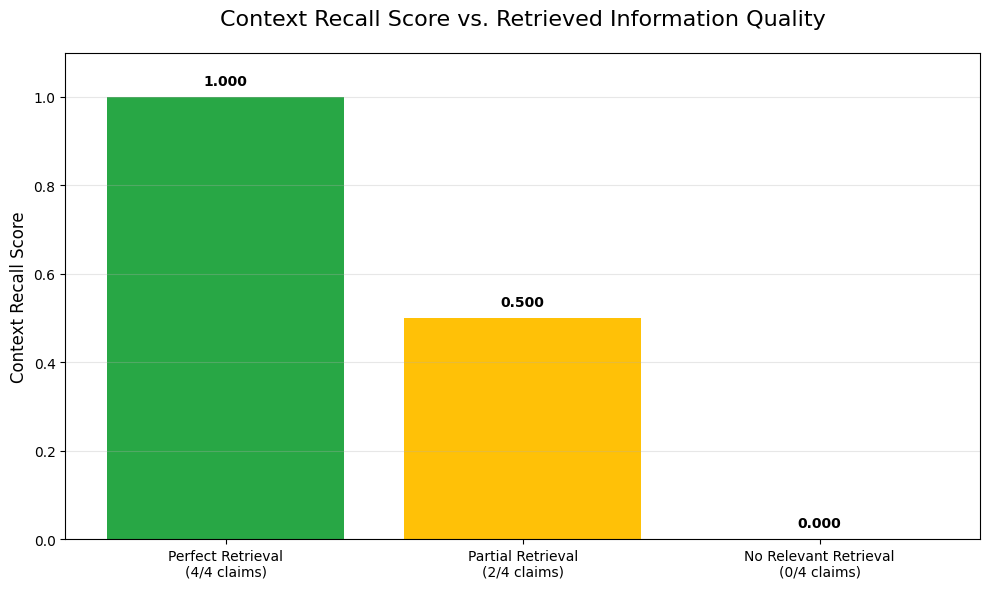

In [12]:
from functions.metric_barchart import plot_metric_comparison

# Define the test scenario
question = "How many tasks are due today?"

# The ground truth contains 4 distinct claims
ground_truth = (
    "1. Finalize Q3 OKRs is due today, "
    "2. Onboard new team member is due today, "
    "3. Update project roadmap is due today, "
    "4. Write thank-you letter is due today."
)

# Test Case 1: Perfect Retrieval - All 4 claims are present
contexts_perfect = [
    [
        "ID 01: Finalize Q3 OKRs - Due: Today",
        "ID 03: Onboard new team member - Due: Today",
        "ID 05: Update project roadmap - Due: Today",
        "ID 14: Write thank-you letter - Due: Today"
    ]
]

# Test Case 2: Partial Retrieval - Only 2 claims are present
contexts_partial = [
    [
        "ID 01: Finalize Q3 OKRs - Due: Today",
        "ID 05: Update project roadmap - Due: Today",
    ]
]

# Test Case 3: No Retrieval - 0 claims are present
contexts_none = [
    [
        "ID 02: Prepare presentation - Due: This Week",
        "ID 08: Clean up email - Due: This Year"
    ]
]

# Create datasets
data_perfect = {"question": [question], "ground_truth": [ground_truth], "contexts": contexts_perfect}
data_partial = {"question": [question], "ground_truth": [ground_truth], "contexts": contexts_partial}
data_none = {"question": [question], "ground_truth": [ground_truth], "contexts": contexts_none}

dataset_perfect = Dataset.from_dict(data_perfect)
dataset_partial = Dataset.from_dict(data_partial)
dataset_none = Dataset.from_dict(data_none)

# Evaluate all three cases
result_perfect = evaluate(dataset_perfect, metrics=[context_recall], llm=ragas_llm, embeddings=ragas_embeddings)
result_partial = evaluate(dataset_partial, metrics=[context_recall], llm=ragas_llm, embeddings=ragas_embeddings)
result_none = evaluate(dataset_none, metrics=[context_recall], llm=ragas_llm, embeddings=ragas_embeddings)

# Extract scores
scores = {
    "Perfect Retrieval\n(4/4 claims)": result_perfect["context_recall"],
    "Partial Retrieval\n(2/4 claims)": result_partial["context_recall"],
    "No Relevant Retrieval\n(0/4 claims)": result_none["context_recall"]
}

# Generate comparison chart
plot_metric_comparison(
    scores_dict=scores,
    title="Context Recall Score vs. Retrieved Information Quality",
    ylabel="Context Recall Score",
)

**图表解读：**  
召回分数会随着检索到的相关信息量线性下降。这证明召回本质上反映的是检索的完整性。

### 提升上下文召回率

* **调整块大小（Chunk Size）：** 如果文本块太小，单条事实可能被拆散到多个块里。尝试将 `chunk_size` 从 128 增大到 512。
* **使用块重叠（Chunk Overlap）：** 在文本切分器中加入 `chunk_overlap=100`，以保留边界处的上下文。
* **优化嵌入模型：** 试试不同的嵌入模型。更符合你领域数据的模型会生成更有意义的向量表示。
* **实施重排序（Re-ranking）：** 使用交叉编码器模型对初次检索结果进行重排，把最相关的文本块提升到前面。
* **采用混合检索：** 将向量检索与关键词检索（如 BM25）结合，捕捉仅靠嵌入可能遗漏的文档。


## 上下文精度（Context Precision）

> 我们检索来了多少噪声？

**衡量内容：**  
上下文精度聚焦于一个关键问题：**我们检索到的所有文本块中，有多少真正与查询相关？**  
它衡量的是检索阶段的信噪比。

**重要性：**  
如果精度得分很低，说明 LLM 正在被大量无关信息“投喂”。这不仅会分散模型注意力、推高处理成本，还可能让模型被“伪线索”误导而给出错误答案。

Ragas 通过“LLM 裁判”来计算该指标。它不是简单的算术运算，而是调用一个独立的“评估器”LLM，综合分析 `question`、`ground_truth` 与 `retrieved_contexts`，评估检索到的文本块对问题的相关程度，以及最有用的信息是否排在列表前列。

因此，这个分数反映的是对检索质量的细致判断，同时考虑了文本块的相关性与排序。

$$
    \text{Precision@k} = {\text{true positives@k} \over  (\text{true positives@k} + \text{false positives@k})}
$$


### 直观示例

我们来看看文本块的排列顺序如何影响 `context_precision` 分数。这里使用一个简单的查询和三组不同的检索结果。

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

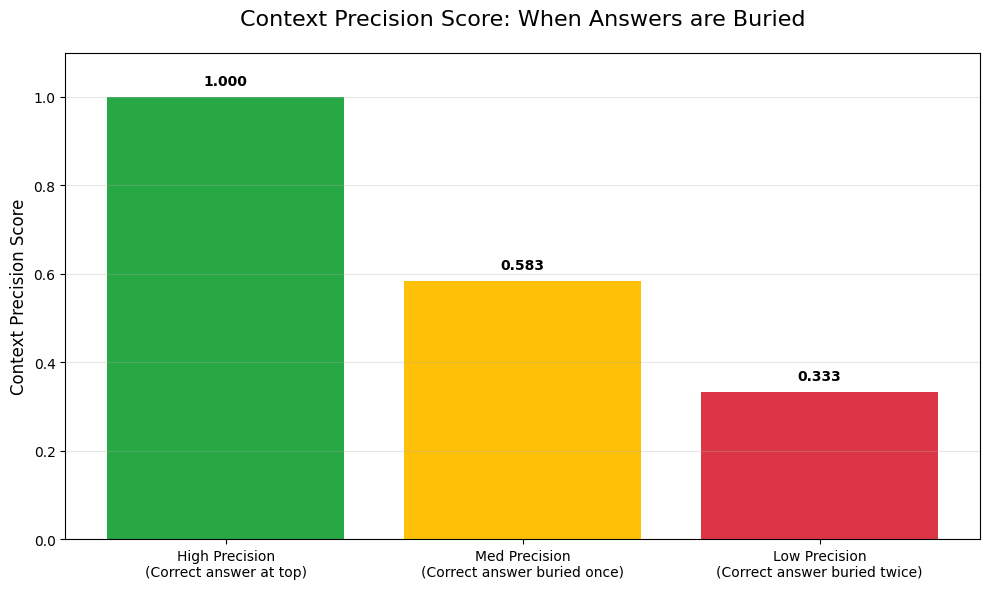

In [13]:
# Define the test scenario
question = "When is the project roadmap due?"

# Ground truth (based on your data, it's "Project Leads")
ground_truth = "The project roadmap is due today."

# Test Case 1: High Precision
contexts_high = [
    [
        "Update project roadmap is due today"
    ]
]

# Test Case 2: Med Precision
contexts_med = [
    [
        "Trip to Norway is in November",
        "Update project roadmap is due today",                   # Correct answer is preceded by one false answer
        "Write to penpal needs to be completed within 24 hours"
    ]
]

# Test Case 3: Low Precision
contexts_low = [
    [
        "Trip to Norway is in November",
        "Write to penpal needs to be completed within 24 hours",
        "Update project roadmap is due today"                    # Correct answer is preceded by two false answers
    ]
]


# Create and evaluate datasets
def create_and_evaluate(contexts_list, question, ground_truth):
    dataset = Dataset.from_dict({
        "question": [question],
        "ground_truth": [ground_truth],
        "contexts": contexts_list
    })
    result = evaluate(dataset, metrics=[context_precision], llm=ragas_llm, embeddings=ragas_embeddings)
    return result["context_precision"]

scores = {
    "High Precision\n(Correct answer at top)": create_and_evaluate(contexts_high, question, ground_truth),
    "Med Precision\n(Correct answer buried once)": create_and_evaluate(contexts_med, question, ground_truth),
    "Low Precision\n(Correct answer buried twice)": create_and_evaluate(contexts_low, question, ground_truth)
}

# Generate comparison chart
plot_metric_comparison(
    scores_dict=scores,
    title="Context Precision Score: When Answers are Buried",
    ylabel="Context Precision Score",
)

**图表解读：**  

* **高分（1.000）：** 评估器 LLM 认为结果完美。唯一检索到的块高度相关，而且排在最前。
* **中等（0.500）：** 评估器 LLM 发现正确信息虽然存在，但前面夹着一个无关块。这类“噪声”会被惩罚，从而显著拉低得分。
* **低分（0.333）：** 评估器 LLM 看到正确信息被两个无关块掩盖。排序质量低，说明噪声很多。

这个实验证明 `context_precision` 不仅关乎“检索到什么”，也关乎“如何排序”。高精度得分意味着检索系统既能找到正确信息，也能以 LLM 易于利用的顺序呈现。

### 提升上下文精度

* **调整相似度阈值：** 筛掉相似度低于某阈值的文本块。
* **使用查询重写：** 例如采用 HyDE（假想文档嵌入）等方法，在检索前生成更优的查询。
* **利用元数据过滤：** 如果数据附带元数据（如 task_type、priority），可在向量检索前据此缩小搜索范围。
* **实现重排序：** 借助重排序器（re-ranker），把向量上接近但无关的文本块压到后面。

优化上下文精度，能让 LLM 面对的是一组干净、聚焦且排序合理的信息，从而最大化产出准确且有用回答的概率。


## 忠实度（Faithfulness）

**衡量内容：**  
忠实度关注的问题是：*LLM 是否出现幻觉？回答是否严格依据提供的上下文？*  
它衡量的是生成答案中有多少陈述能够被检索到的上下文直接支持。

**重要性：**  
这是构建可信 AI 的关键。忠实度高意味着 LLM 不在凭空捏造内容，而是基于证据给出回答。

计算方法与召回类似，但方向相反：

$$
    \text{Faithfulness Score} = \frac{\text{回答中得到检索上下文支持的陈述数量}}{\text{回答中的陈述总数}}
$$

### 直观示例
我们来构造一个包含幻觉的回答。



Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

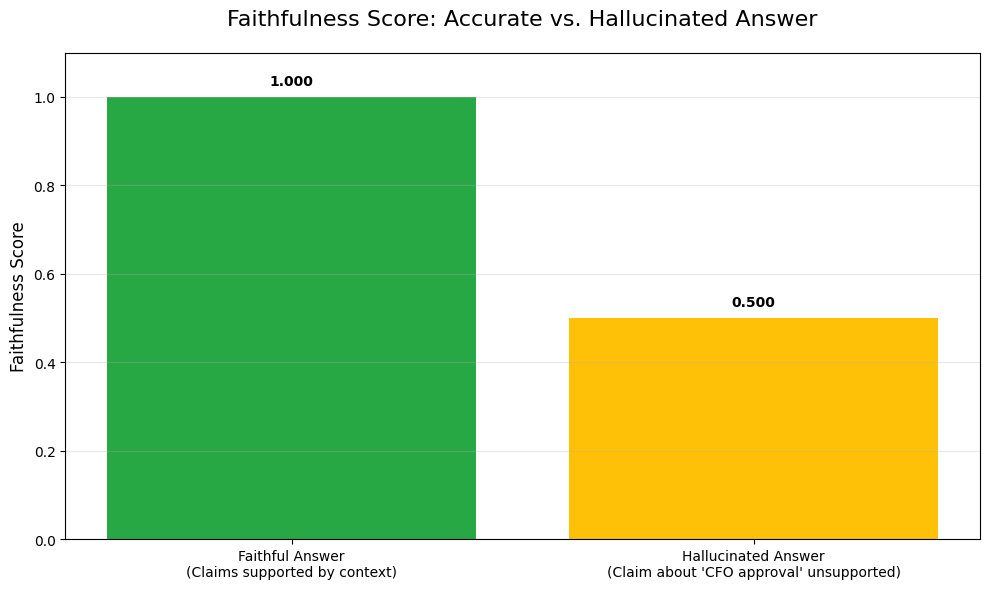

In [14]:
# Define the test case
question = "When is the 'Develop 3-year plan' task due?"

# The ground truth
ground_truth = "This Year"

# The retrieved context (our source of truth)
contexts = [
    [
        "The 'Develop 3-year plan' task is due 'This Year'.",
        "The 'Finalize Q3 OKRs' task is due 'Today'."
    ]
]

# Test Case 1: Faithful Answer
answer_faithful = "The 'Develop 3-year plan' task is due 'This Year.'"

# Test Case 2: Hallucinated Answer
answer_hallucinated = "The 'Develop 3-year plan' task is due 'This Year,' and it must be approved by the CFO before submission."

# Create datasets
dataset_faithful = Dataset.from_dict({
    "question": [question],
    "answer": [answer_faithful],
    "contexts": contexts
})

dataset_hallucinated = Dataset.from_dict({
    "question": [question],
    "answer": [answer_hallucinated],
    "contexts": contexts
})

# Evaluate
result_faithful = evaluate(dataset_faithful, metrics=[faithfulness], llm=ragas_llm, embeddings=ragas_embeddings)
result_hallucinated = evaluate(dataset_hallucinated, metrics=[faithfulness], llm=ragas_llm, embeddings=ragas_embeddings)

# Prepare data for comparison
scores = {
    "Faithful Answer\n(Claims supported by context)": result_faithful["faithfulness"],
    "Hallucinated Answer\n(Claim about 'CFO approval' unsupported)": result_hallucinated["faithfulness"]
}

# Generate comparison chart
plot_metric_comparison(
    scores_dict=scores,
    title='Faithfulness Score: Accurate vs. Hallucinated Answer',
    ylabel='Faithfulness Score'
)

**图表解读：**  
带有幻觉的回答获得了更低的忠实度得分。关于“需要 CFO 批准”的陈述没有任何上下文支撑，因而拉低了整体得分。

### 提升忠实度

* **强化提示词：** 明确写出“请仅根据下方上下文作答；若上下文未包含答案，请回答‘I don't know.’”等指令。
* **更换 LLM：** 不同 LLM 的幻觉倾向差异很大，可考虑选择更注重扎根事实的模型。
* **对答案做后处理：** 加一道验证流程，由另一模型检查回答是否得到上下文支持。

## 答案正确度（Answer Correctness）

**衡量内容：**   
答案正确度是面向用户的“终极指标”。  
它回答的问题是：*最终答案与参考答案相比，是否正确且完整？*

**重要性：**
这是用户真正看到的部分。高正确度意味着系统正在输出有价值的结果。

Ragas 将语义相似度（回答是否表达相同含义）与事实准确性（具体事实是否正确）融合为一个分数，使用类似 F1 的方式计算事实重叠度。事实准确性会度量生成答案与参考答案之间事实的重合情况，对应以下概念：

答案正确度的计算公式如下：

$$
    \text{F1 Score} = {|\text{TP}| \over {(|\text{TP}| + 0.5 \times (|\text{FP}| + |\text{FN}|))}}
$$

其中：

* **TP（真正）：** 同时出现在参考答案和生成答案中的事实或陈述。
* **FP（假正）：** 仅出现在生成答案而不在参考答案中的事实或陈述。
* **FN（假负）：** 仅出现在参考答案而不在生成答案中的事实或陈述。


### 直观示例

我们来比较一个完美答案、一个部分正确的答案，以及一个错误答案。



Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

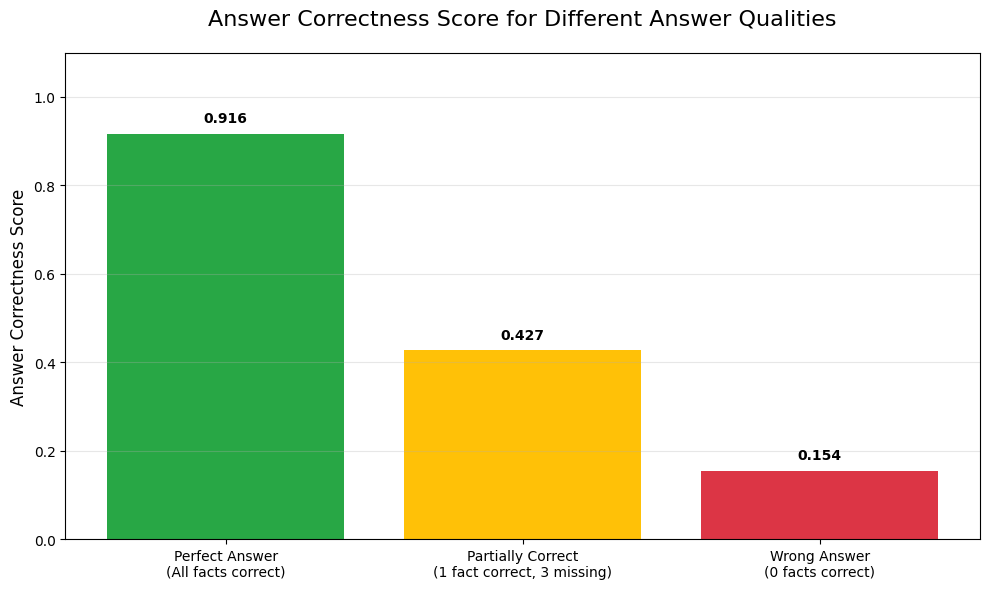

In [15]:
# Ground truth
ground_truth = "4 tasks are due today: Finalize Q3 OKRs, Onboard new team member, Update project roadmap, Write thank-you letter to penpal."

# Define test cases
test_cases = [
    {
        "answer": "There are 4 tasks due today: Finalize Q3 OKRs, Onboard new team member, Update project roadmap, and Write thank-you letter to penpal.",
        "label": "Perfect Answer\n(All facts correct)"
    },
    {
        "answer": "One task is due today: Finalize Q3 OKRs.",
        "label": "Partially Correct\n(1 fact correct, 3 missing)"
    },
    {
        "answer": "No tasks are due today.",
        "label": "Wrong Answer\n(0 facts correct)"
    }
]

# Evaluate each case
scores = {}
for case in test_cases:
    dataset = Dataset.from_dict({
        "question": [question],
        "answer": [case["answer"]],
        "ground_truth": [ground_truth]
    })
    result = evaluate(dataset, metrics=[answer_correctness], llm=ragas_llm, embeddings=ragas_embeddings)
    scores[case["label"]] = result["answer_correctness"]

# Generate the chart using our reusable function
plot_metric_comparison(
    scores_dict=scores,
    title='Answer Correctness Score for Different Answer Qualities',
    ylabel='Answer Correctness Score'
)

**图表解读：**  
得分直接反映最终输出的质量——完整性越高、错误越少，得分越高。

### 提升答案正确度

* **先解决上游问题：** 答案正确度往往只是症状。利用其他指标（例如低召回）来定位根因。
* **优化提示词：** 使用鼓励结构化、完整回答的提示，例如“列出今天到期的所有任务”。
* **启用多步推理：** 换用更强大的 LLM，或提示它“逐步思考”，避免遗漏细节。


## 从指标中提炼可执行洞见

评估的真正价值在于组合这些指标。如果单独看某一个，很容易产生误导。诊断的魔力在于综合分析。

```mermaid
graph TD
    classDef frameworkStyle fill:#ffffff,stroke:#1f77b4,stroke-width:2px;

    subgraph flowchat [Diagnosis Flowchart]
        A[Low Answer Correctness] --> C{Low Context Recall}
        C -->|Yes| D[Retrieval Problem: <br>Critical info missing.<br>Fix chunking/embeddings.]
        C -->|No| E{Low Context Precision}
        E -->|Yes| F[Distracted LLM: <br>Too much noise in context.<br>Improve retrieval filtering/re-ranking.]
        E -->|No| G{Low Faithfulness}
        G -->|Yes| H[Generation Problem: <br>LLM is hallucinating.<br>Fix prompt or LLM.]
        G -->|No| I[Answer Formatting/Completeness Issue: <br>Answer is correct but incomplete or poorly structured.]
    end

    class flowchat frameworkStyle;
```

总之，我们可以把已掌握的内容浓缩成一张简单的表格。

<table class='diagnostic-table'>
    <tr>
        <th>指标</th>
        <th>高值 (≥0.8)</th>
        <th>中值 (0.5–0.8)</th>
        <th>低值 (<0.5)</th>
    </tr>
    <tr>
        <td><strong>Context Recall</strong></td>
        <td class='high'>检索器找到了大部分相关信息</td>
        <td class='medium'>错过了一些关键信息</td>
        <td class='low'>缺少关键信息——需要修复检索</td>
    </tr>
    <tr>
        <td><strong>Context Precision</strong></td>
        <td class='high'>检索到的文本块高度相关</td>
        <td class='medium'>检索上下文略有噪声</td>
        <td class='low'>无关信息过多——LLM 容易被干扰</td>
    </tr>
    <tr>
        <td><strong>Faithfulness</strong></td>
        <td class='high'>回答紧贴检索上下文</td>
        <td class='medium'>存在轻微幻觉或遗漏</td>
        <td class='low'>严重幻觉——需要修提示或更换模型</td>
    </tr>
    <tr>
        <td><strong>Answer Correctness</strong></td>
        <td class='high'>答案事实准确且完整</td>
        <td class='medium'>部分正确或不够完整</td>
        <td class='low'>答案错误——应检查整条管线</td>
    </tr>
    <tr>
        <td colspan="4" class='insight'>
            <strong>核心洞见：</strong> 
            如果 <strong>Context Recall</strong> 低但 <strong>Faithfulness</strong> 高，说明 LLM 没撒谎——它只是拿到错误信息。 
            这时应该修检索（块划分、嵌入），而不是怪生成。
        </td>
    </tr>
</table>

# 其他评估框架

虽然 Ragas 在自动化、LLM 驱动的评估方面表现优异，但它并非唯一的选择。下面我们来看看其他几种常用框架——它们各有千秋。

## Ragas（我们的首选）

```mermaid
graph TD
    classDef frameworkStyle fill:#ffffff,stroke:#1f77b4,stroke-width:2px;

    subgraph Ragas_Framework [Ragas Framework]
        direction TB
        
        subgraph Ragas_Evaluator [Ragas Evaluator]
            direction LR
            Judge[LLM Judge] -->|Scores| CR[Context Recall]
            Judge -->|Scores| CP[Context Precision]
            Judge -->|Scores| F[Faithfulness]
            Judge -->|Scores| AC[Answer Correctness]
        end

        Q[User Question] --> Ragas
        A[Generated Answer] --> Ragas
        C[Retrieved Context] --> Ragas
        GT[Ground Truth] --> Ragas
        Ragas --> Judge
        
    end
    
    class Ragas_Framework frameworkStyle;
    
    style Judge fill:#e1f5fe,stroke:#1f77b4
    style Ragas stroke:#1f77b4,stroke-width:2px
```

> Ragas 使用独立的 LLM 作为“裁判”，自动为 RAG 系统的输出打分。它需要参考答案进行对比，可快速给出整体性能评估。

Ragas 是专为 RAG 应用打造的开源框架，其优势在于一组针对 RAG 的指标，例如上下文召回、上下文精度、忠实度与答案相关性，可直击检索增强系统的常见薄弱点。借助“LLM 裁判”，Ragas 能为生成答案的质量及其与检索上下文的扎根程度提供细腻的评分，因此非常适合快速获得 RAG 管线整体健康状况的自动化评估。不过，由于它依赖 LLM 评估器，得分有时会像“黑箱”，让人难以弄清具体扣分原因，从而增加调试难度。

## TruLens

```mermaid
graph LR
    classDef frameworkStyle fill:#ffffff,stroke:#1f77b4,stroke-width:2px;
    
    subgraph TruLens_Framework [TruLens Framework]
        A[User Query] --> B[TruLens Monitor]
        B --> C[Chunking & Retrieval]
        B --> D[Prompt Assembly]
        B --> E[LLM Generation]
        B --> F[Final Answer]

        subgraph TruLens Dashboard
            G[Log: Query]
            H[Log: Retrieved Chunks]
            I[Log: Final Prompt]
            J[Log: LLM Call]
            K[Log: Answer]
            G --> H --> I --> J --> K
        end

        B --> G
        B --> H
        B --> I
        B --> J
        B --> K
    
    end
        
    class TruLens_Framework frameworkStyle;
```

> TruLens 像飞行记录仪一样捕捉 RAG 管线的每个步骤，非常适合深入调试并定位问题所在。

TruLens 的特色在于可观测性与可追踪性。它不仅提供最终得分，更像 LLM 应用的“黑匣子”，从最初的查询到最终答案、包括中间的提示词、检索上下文与模型调用，都会被记录下来。这种细节对调试复杂问题极为宝贵。凭借与 LlamaIndex 等框架的集成，开发者可以设置反馈函数，在不同阶段程序化地评估扎根性与相关性。虽然 TruLens 内置指标不如其他框架丰富，也需要更多配置，但它为整个管线提供的全景视图对定位问题极其有用。

## DeepEval

```mermaid
graph TD
    subgraph DeepEval Framework
        T[Define Test Cases] -->|Question, Ground Truth| DE[DeepEval]
        DE -->|Run Tests| A1[Test: Answer Correctness]
        DE -->|Run Tests| A2[Test: Faithfulness]
        DE -->|Run Tests| A3[Test: Context Recall]

        A1 -->|Pass/Fail| R[CI/CD Pipeline]
        A2 -->|Pass/Fail| R
        A3 -->|Pass/Fail| R
    end
    
    style DE fill:#ffecb3,stroke:#f57c00,stroke-width:2px
    style R fill:#e8f5e8,stroke:#2e7d32
```
> DeepEval 将 RAG 评估视作软件测试。你定义断言，它执行自动化测试，非常适合在生产环境中防止回归。 

DeepEval 采用软件工程思路，被称为“面向 LLM 的 Pytest”。它倡导测试驱动开发（TDD），鼓励你在构建 RAG 应用之前或同时编写评估测试。该框架在 CI/CD 场景中表现突出，可以设定严格的通过/失败标准（例如“faithfulness > 0.9”）来防止退化。DeepEval 支持多种 LLM 任务的指标，不限于 RAG，因此对于构建多类型 LLM 功能的团队尤为实用。其结构化、断言式的测试模型为生产级质量把控提供了高度的自动化与掌控力。

## 自定义评估框架

当标准指标无法覆盖你应用的特定需求时，自定义评估框架就显得不可或缺。例如，检查回答中是否包含指定链接、是否遵循某个工作流程，甚至是否符合预期情绪语调。自建方案虽然投入最大，却能让评估与业务目标和用户体验精确对齐。值得注意的是，这些框架并非互斥；成熟的评估策略通常组合使用，例如用 Ragas 做广覆盖的自动打分、用 TruLens 深挖异常案例，再用自定义规则保障关键业务逻辑。


## 框架对比

| 功能 | **Ragas** | **TruLens** | **DeepEval** | **自定义框架** |
| :--- | :--- | :--- | :--- | :--- |
| **最适用场景** | 为 RAG 系统提供端到端的自动化指标评分。 | 提供可观测性、调试能力，追踪整条 RAG 管线。 | 测试驱动开发（TDD）与 CI/CD 集成。 | 强制执行特定业务逻辑与领域规则。 |
| **优势** | 轻量、易集成，指标专为 RAG 设计（如上下文召回、忠实度），利用 LLM 裁判输出细腻评分。 | 拥有可视化面板，记录管线每一步，与 LangChain、LlamaIndex 集成良好，可实时反馈。 | 设计理念类似软件测试框架（如 pytest），支持断言与自动回归测试。 | 最大的灵活性，可定义现成工具无法覆盖的独特指标（如政策合规、情绪语调）。 |
| **劣势** | 需要能力足够的评估型 LLM；评分可能“黑箱”，低分难以解释；指标含义不一定直观。 | 内置指标相对较少；相比简单工具需要更多配置。 | 对复杂自定义逻辑可能需要更多设置；侧重验证而非深度管线分析。 | 开发与维护成本高，需要大量工程投入。 |
| **适用用例** | 快速获取 RAG 管线性能的自动化得分，定位宏观问题。 | 通过检查中间步骤、提示词和检索上下文，深入调试故障管线。 | 在生产环境中自动化质量检查，确保更新不会破坏既有功能。 | 验证 AI 回答是否遵循严格业务规则，例如包含指定链接或遵循客服话术。 |

# 建立评估框架的最佳实践

---

你已经掌握了一套强大的工具：手动检查用来诊断问题、Ragas 的自动化指标帮助你在规模上衡量表现、还有可以选择的多种框架。但真正的挑战不是“会用这些工具”，而是打造一套可持续、有效的评估实践，推动持续改进。

把它想象成维护一台高性能引擎。再先进的诊断工具，如果没有定期保养、专业技师和详尽记录，发动机最终也会出故障。

以下是为 RAG 应用构建稳健评估体系的关键步骤。

## 让领域专家尽早参与

成功的评估策略，最重要的因素是人的专业判断。再强大的 LLM 判断器，也比不过熟悉业务细节的专家。

> **重要性：**  
> 只有真正深入业务的人才能界定什么才算“正确”。“高优先级”的任务是否比“今日截止”更紧急？回答是否必须包含链接、截止日期或审批流程？

### 实践方式：

* **共同编写 ground truth：** 不要单独写 `ground_truth`。与专家（如 HR 经理、项目负责人）坐下来一起撰写理想回答。
* **识别边缘情景：** 专家最了解棘手场景。例如“任务已过期但状态仍是 Not Started？”或“刚删除的任务被询问怎么办？”
* **审查指标：** 定期请专家复核低分案例，确认是指标判断正确，还是应该更新参考答案。

> **💡 专家提示：**  
> 把领域专家当成副驾驶，而不是事后审阅者。他们的洞见应该从第一天就融入评估标准。

## 用真实用户查询构建测试集

评估数据集是质量保障的基石。如果它源于假设问题，评估结果也难以反映真实表现。

**真实查询来自哪里：**

* **聊天记录：** 挖掘客服机器人、内部聊天工具或早期用户测试的对话。
* **搜索历史：** 查看用户在知识库或 Wiki 中搜索的内容。
* **工单：** 支持工单是用户痛点和模糊表达的宝库。

### 聚焦高价值问题：

**优先关注：**

* **高频问题：** 经常出现的提问。
* **高风险问题：** 与截止时间、政策或财务信息相关的请求。
* **模糊问题：** 多种解释的提问（例如“本周截止的是什么？” vs.“今天截止的是什么？”）。

这样才能让评估努力聚焦在对用户最重要的领域。

## 混合使用多种评估方法

没有任何单一工具能呈现全貌。最有效的团队会采用分层诊断组合：

| 方法 | 目的 | 优势 | 局限性 |
|--------|--------|-----------|-------------|
| **Manual Inspection** | 直观验证检索与输出质量 | 快速、直观，能发现格式问题 | 难以扩展、主观性强 |
| **TruLens** | 追踪并调试完整 RAG 管线 | 展示提示词、上下文、LLM 调用 | 不直接给出质量得分 |
| **Ragas** | 用指标量化性能 | 提供客观评分（正确度、忠实度） | 需要参考答案 |
| **LLM-as-a-Judge** | 自动评估回答质量 | 可衡量语气、相关性、完整性 | 可能出现评估幻觉 |
| **A/B Testing** | 比较提示或检索策略变化 | 能衡量真实用户影响 | 需要真实流量与指标 |

> 💡 **最佳实践**：结合 **TruLens 调试** + **Ragas 打分** + **人工审查边缘案例**。
### 示例工作流：

1. 使用 Ragas 做日常自动化运行，及时发现性能下降。
2. 当得分偏低时，借助 TruLens 深入日志，定位具体问题。
3. 编写 DeepEval 测试，确保该问题不会再次出现。
4. 面向新功能（例如退款政策），编写自定义评估器，确保回答始终包含指定链接。

## 闭合反馈回路

评估不是一次性任务，而是持续改进的循环。目标是构建一个飞轮，每转一圈，系统就更可靠。

```mermaid
graph LR
    subgraph Quality_Flywheel [Quality Flywheel]
        A[Collect Bad Cases] --> B[Analyze Metrics]
        B --> C[Improve Chunking/Prompting]
        C --> D[Re-evaluate]
        D --> E[Deploy]
        E --> A
    end
```

### 实施质量飞轮

* **Collect：** 汇集失败用例、用户反馈与低分查询。
* **Analyze：** 利用指标诊断根因（例如召回低 → 修检索）。
* **Improve：** 有针对性地修改（调整块大小、重写提示等）。
* **Re-evaluate：** 运行测试集验证修复效果。
* **Deploy：** 发布改进版本。
* **Repeat：** 不断循环，持续增强系统可靠性。

## 把评估当成产品

评估框架与应用代码一样重要，需要同样严格对待。

* **版本控制：** 将测试用例、参考答案与评估脚本与主代码一起存入 Git。
* **完整文档：** 说明每个测试用例为何存在、旨在捕捉什么问题。
* **监控趋势：** 持续追踪关键指标（如平均答案正确度）。分数突然下降就是预警。
* **接入 CI/CD：** 将评估套件集成到部署流程中。例如，当忠实度低于 0.8 时直接阻止构建。

# 接下来做什么？

---

## 答题自测！

<details>
<summary style="cursor: pointer; padding: 12px; border: 1px solid #dee2e6; border-radius: 6px;">
<b>1. 你的 RAG 系统给出了正确答案，但 `context_recall` 得分很低。最可能的原因是什么？</b>  

<ul>
    <li>A) LLM 被无关文本块干扰  </li>
    <li>B) 回答不完整  </li>
    <li>C) 检索到的上下文不包含必要信息  </li>
    <li>D) LLM 在幻觉</li>
</ul>

**查看答案 →**
</summary>

<div style="margin-top: 10px; padding: 15px; border: 1px solid #dee2e6; border-radius: 0 0 6px 6px;">

✅ **正确答案：** C) 检索到的上下文不包含必要信息  
📝 **说明**：
* `context_recall` 低意味着正确信息没有被检索到。如果答案依然正确，那就只能是模型“凭空补充”了事实——这是一种危险的失败模式，说明检索已出问题，而 LLM 在帮它“擦屁股”。

</div>
</details>

## 要点回顾

* **为什么要评估 RAG 系统？**
    * **RAG 是一条管线，而非单一步骤**——涉及分块、检索、上下文组装与生成。
    * **当事情出错时，根因往往不明**——是模型幻觉，还是根本没检索到正确上下文？
    * **评估能区分症状与根因：**
      - 错误答案可能来自糟糕的检索、提示或模型限制。
    * **没有评估就像蒙着眼上线**——看不到问题也就无法改进。
    * **评估带来信任、可扩展性与迭代能力**——这是生产级 AI 的基础。

<br>

* **手动评估**
    * **视觉检查是第一步**
    * **留意预警信号：**
      - 缺少关键关键词
      - 文本块覆盖不全
      - 文本被破坏或乱码
    * **手动调试能培养直觉**——理解检索与生成如何互动。
    * **始终检查原始节点**——确认模型是否拿到了正确信息，再决定是否怪 LLM。

<br>


* **使用 Ragas 做自动化评估**
    * **Ragas 提供量化指标**——把主观质量转化为可测分数。
    * 核心指标：
      - **Answer Correctness**：回答在事实层面有多准确。
      - **Context Recall**：检索上下文是否包含所有相关事实。
      - **Context Precision**：检索文本块是否相关，是否存在大量噪声。
      - **Faithfulness**：回答是否源自上下文，而非幻觉。
    * **Ragas 让评估进入 CI/CD 流程**——测试、打分、放心上线。

<br>

* **构建贴近真实的评估数据集**
    * **使用真实用户提问**——不要凭空杜撰：
      - 聊天记录
      - 搜索历史
      - 支持工单
    * **加入模糊、含糊或多问一题的场景**——这些最难也最能暴露问题。
    * **定义清晰的参考答案**——每个问题的“正确答案”是什么？
    * **把领域专家当副驾驶**——他们的见解应从第一天起塑造你的评估标准。
    * **小规模起步，但要尽早**——哪怕只有 10 个高质量用例，也能揭示系统性问题。

<br>

* **解读指标**
    * **指标是诊断工具，不是成绩单：**
      - `context_recall` 低 → 修检索（优化分块、嵌入或搜索）
      - `answer_correctness` 低 → 优化提示或换更强的模型
      - `context_precision` 高但 `answer_correctness` 低 → 模型在忽略优质上下文
    * **不要孤立看指标**——组合分析才能找到根因。
    * **举例：** 答案正确 + 召回低 = 幻觉（危险！）
    * **评估是迭代的**——测量、修复、再测量。

<br>

* **从评估中提炼可执行洞见**
    * **先修上游问题**——答案正确度往往只是症状。结合其他指标定位根因：
      - 检索失败？→ 改进分块或嵌入
      - 提示欠佳？→ 加入结构、示例或链式思考
    * **优化提示**——采用如下指令：
      - “列出今天到期的所有任务。”
      - “请用项目符号作答。”
    * **启用多步推理**——使用具备思考模式的推理模型（如 Qwen-plus），减少遗漏细节。
    * **评估的真正价值**不在分数，而在于这些分数激发的**洞见**，它们能促成更合理的系统设计。

# 下一步？

---

## 自测小练！

<details>
<summary style="cursor: pointer; padding: 12px; border: 1px solid #dee2e6; border-radius: 6px;">
<b>1. 你的 RAG 系统给出了正确答案，但 `context_recall` 得分很低。最可能的原因是什么？</b>  

<ul>
    <li>A) LLM 被无关文本块干扰  </li>
    <li>B) 回答不完整  </li>
    <li>C) 检索到的上下文不包含必要信息  </li>
    <li>D) LLM 在幻觉</li>
</ul>

**查看答案 →**
</summary>

<div style="margin-top: 10px; padding: 15px; border: 1px solid #dee2e6; border-radius: 0 0 6px 6px;">

✅ **正确答案：** C) 检索到的上下文不包含必要信息  
📝 **说明**：
* `context_recall` 低意味着正确信息没有被检索到。如果答案依然正确，那只能说明模型“凭空补充”了事实——这是一种危险的失败模式，表示检索阶段已经出问题，而 LLM 在替它“擦屁股”。

</div>
</details>

## 要点回顾

* **为什么要评估 RAG 系统？**
    * **RAG 是一条管线，而非单一步骤**——涉及分块、检索、上下文组装与生成。
    * **当事情出错时，根因往往不明**——是模型幻觉，还是压根没检索到正确上下文？
    * **评估能区分症状与根因：**
      - 错误答案可能来自糟糕的检索、提示或模型限制。
    * **没有评估就像蒙着眼上线**——看不到问题也就无法改进。
    * **评估带来信任、可扩展性与迭代能力**——这是生产级 AI 的基石。

<br>

* **手动评估**
    * **视觉检查是第一步**
    * **留意预警信号：**
      - 缺少关键关键词
      - 文本块覆盖不全
      - 文本被破坏或乱码
    * **手动调试能培养直觉**——理解检索与生成如何互动。
    * **始终检查原始节点**——确认模型是否拿到了正确信息，再决定是否怪 LLM。

<br>

* **使用 Ragas 做自动化评估**
    * **Ragas 提供量化指标**——把主观质量转化为可测分数。
    * 核心指标：
      - **答案正确度（Answer Correctness）**：回答在事实层面有多准确。
      - **上下文召回率（Context Recall）**：检索上下文是否包含所有相关事实。
      - **上下文精度（Context Precision）**：检索文本块是否相关，是否存在大量噪声。
      - **忠实度（Faithfulness）**：回答是否源自上下文，而非幻觉。
    * **Ragas 让评估进入 CI/CD 流程**——测试、打分、放心上线。

<br>

* **构建贴近真实的评估数据集**
    * **使用真实用户提问**——不要凭空杜撰：
      - 聊天记录
      - 搜索历史
      - 支持工单
    * **加入模糊、含糊或多问一题的场景**——这些最难也最能暴露问题。
    * **定义清晰的参考答案**——每个问题的“正确答案”是什么？
    * **把领域专家当副驾驶**——他们的见解应从第一天起塑造你的评估标准。
    * **小规模起步，但要尽早**——哪怕只有 10 个高质量用例，也能揭示系统性问题。

<br>

* **解读指标**
    * **指标是诊断工具，不是成绩单：**
      - `context_recall` 低 → 修检索（优化分块、嵌入或搜索）
      - `answer_correctness` 低 → 优化提示或换更强的模型
      - `context_precision` 高但 `answer_correctness` 低 → 模型在忽略优质上下文
    * **不要孤立看指标**——组合分析才能找到根因。
    * **举例：** 答案正确 + 召回低 = 幻觉（危险！）
    * **评估是迭代的**——测量、修复、再测量。

<br>

* **从评估中提炼可执行洞见**
    * **先修上游问题**——答案正确度往往只是症状。结合其他指标定位根因：
      - 检索失败？→ 改进分块或嵌入
      - 提示欠佳？→ 加入结构、示例或链式思考
    * **优化提示**——采用如下指令：
      - “列出今天到期的所有任务。”
      - “请用项目符号作答。”
    * **启用多步推理**——使用具备思考模式的推理模型（如 Qwen-plus），减少遗漏细节。
    * **评估的真正价值**不在分数，而在于这些分数激发的**洞见**，它们能促成更合理的系统设计。